# Custom model training for gesture recognition

Import the required libraries

In [41]:
import csv
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

Load the list of gesture form the `gesture_list.csv` file

In [42]:
# Define which gestures should be detected by the model
gesture_list = np.loadtxt("gesture_list.csv", delimiter=',', dtype=str)
print(gesture_list)
num_gestures = len(gesture_list)

['none' 'open' 'fist' 'pick' 'index' 'two' 'three' 'four' 'L']


Load the dataset from the file

In [43]:

dataset_filepath = "dataset.csv"
handedness = np.loadtxt(dataset_filepath, delimiter=',', dtype=np.str_, usecols=(0))
y_data_labels = np.loadtxt(dataset_filepath, delimiter=',', dtype=np.str_, usecols=(1))
x_data = np.loadtxt(dataset_filepath, delimiter=',', dtype=np.float32, usecols=list(range(2, (21*3)+2)))

In [44]:
print(handedness[0])
print(y_data_labels[0])
print(x_data.shape)
print(x_data[0].shape)

Left
open
(1994, 63)
(63,)


In [45]:
unique, counts = np.unique(y_data_labels, return_counts=True)
label_count = dict(zip(unique, counts))
for elem in label_count:
    print(f"{elem}: {label_count[elem]}")

L: 300
fist: 394
four: 200
index: 300
open: 200
pick: 200
three: 200
two: 200


Normalize data: convert to N x 21 x 3 -> normalization -> convert to N x 63

In [46]:
N = x_data.shape[0]
x_data_tensor = np.zeros((N,21,3))
for i in range(N):
    for j in range(21):
        for k in range(3):
            x_data_tensor[i,j,k] = x_data[i, 3*j+k]

assert x_data[200,15] == x_data_tensor[200, 5, 0]

from landmark_normalizer import normalize_landmarks
    
x_data_normalized = np.zeros_like(x_data)
for i, gesture in enumerate(x_data_tensor):
    x_data_normalized[i] = normalize_landmarks(gesture, handedness[i]).reshape(-1)
    
assert x_data_normalized.shape == x_data.shape

x_data = x_data_normalized

Define the ID of each gesture. The ID coincides with the row number in the file

In [47]:
y_data = np.zeros((y_data_labels.shape[0]))
for i, label in enumerate(y_data_labels):
    for j, gesture in enumerate(gesture_list):
        if label == gesture and gesture in gesture_list:
            # "Substitute" the label with the gesture id
            y_data[i] = j

Split the dataset into training and validation sets

In [48]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, train_size=0.75)
print(f"Y training set: {y_train}")

Y training set: [2. 1. 2. ... 8. 2. 5.]


Define the model architechture

In [49]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 3, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(num_gestures, activation='softmax')
])
model.summary()

# Path where to save the model
model_save_path = "model/gesture_classifier.keras"
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_4 (Dropout)         (None, 63)                0         
                                                                 
 dense_6 (Dense)             (None, 20)                1280      
                                                                 
 dropout_5 (Dropout)         (None, 20)                0         
                                                                 
 dense_7 (Dense)             (None, 20)                420       
                                                                 
 dropout_6 (Dropout)         (None, 20)                0         
                                                                 
 dense_8 (Dense)             (None, 10)                210       
                                                                 
 dense_9 (Dense)             (None, 9)                

Compile the model

In [50]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

Training step

In [51]:
model.fit(
    x_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(x_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
 1/12 [=>............................] - ETA: 8s - loss: 2.3734 - accuracy: 0.0391
Epoch 1: saving model to model/gesture_classifier.keras
12/12 [==============================] - 1s 19ms/step - loss: 2.3119 - accuracy: 0.0502 - val_loss: 2.2113 - val_accuracy: 0.0902
Epoch 2/1000
 1/12 [=>............................] - ETA: 0s - loss: 2.2978 - accuracy: 0.0234
Epoch 2: saving model to model/gesture_classifier.keras
12/12 [==============================] - 0s 7ms/step - loss: 2.2371 - accuracy: 0.0776 - val_loss: 2.1819 - val_accuracy: 0.2385
Epoch 3/1000
 1/12 [=>............................] - ETA: 0s - loss: 2.2126 - accuracy: 0.0625
Epoch 3: saving model to model/gesture_classifier.keras
12/12 [==============================] - 0s 7ms/step - loss: 2.1935 - accuracy: 0.1003 - val_loss: 2.1712 - val_accuracy: 0.2044
Epoch 4/1000
 1/12 [=>............................] - ETA: 0s - loss: 2.1956 - accuracy: 0.1484
Epoch 4: saving model to model/gesture_classifier.keras
12/1

Validation step

In [52]:
val_loss, val_acc = model.evaluate(x_test, y_test, batch_size=128)

4/4 [==============================] - 0s 1ms/step - loss: 0.1741 - accuracy: 0.9579


Save the model with inference optimizations

In [53]:
model.save(model_save_path)

## Confusion matrix

16/16 [==============================] - 0s 921us/step


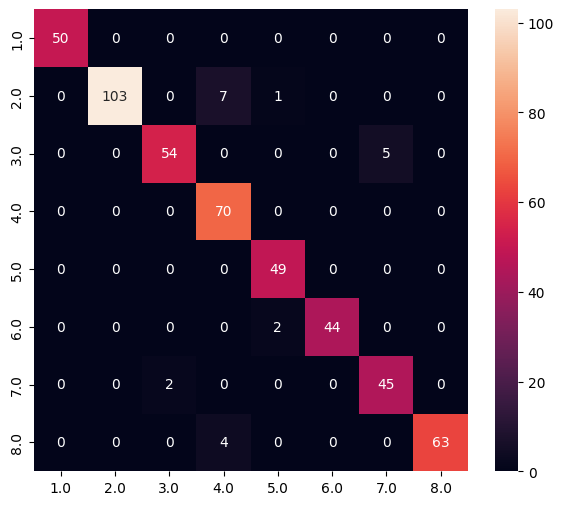

Classification Report
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        50
         2.0       1.00      0.93      0.96       111
         3.0       0.96      0.92      0.94        59
         4.0       0.86      1.00      0.93        70
         5.0       0.94      1.00      0.97        49
         6.0       1.00      0.96      0.98        46
         7.0       0.90      0.96      0.93        47
         8.0       1.00      0.94      0.97        67

    accuracy                           0.96       499
   macro avg       0.96      0.96      0.96       499
weighted avg       0.96      0.96      0.96       499



In [54]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(x_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

In [55]:
i = 678
predict_result = model.predict(np.array([x_data[i]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))
print(y_data[i])

1/1 [==============================] - 0s 19ms/step
[2.3621288e-10 9.3887656e-06 1.0045905e-04 3.5215342e-07 9.6849281e-01
 5.1454927e-06 2.9618834e-08 4.7689699e-08 3.1391870e-02]
4
4.0


Convert to tflite model and save

In [56]:
tflite_save_path = "model/gesture_classifier.tflite"

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: /tmp/tmprwqx1rbg/assets


INFO:tensorflow:Assets written to: /tmp/tmprwqx1rbg/assets
2024-10-28 15:51:08.153233: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2024-10-28 15:51:08.153330: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2024-10-28 15:51:08.153994: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmprwqx1rbg
2024-10-28 15:51:08.156470: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2024-10-28 15:51:08.156510: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /tmp/tmprwqx1rbg
2024-10-28 15:51:08.160633: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2024-10-28 15:51:08.206010: I tensorflow/cc/saved_model/loader.cc:215] Running initialization op on SavedModel bundle at path: /tmp/tmprwqx1rbg
2024-10-28 15:51:08.219305: I tensorflow/cc/saved_model/loader.cc:314] SavedModel

6880

In [57]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

i = 452
interpreter.set_tensor(input_details[0]['index'], np.array([x_data[i]]))

# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))
print(y_data[i])

[1.3373168e-10 9.9545372e-01 2.8362446e-03 2.2050965e-04 2.7430311e-04
 8.3466480e-12 4.9324354e-11 1.6505247e-07 1.2150527e-03]
1
1.0
